<a href="https://colab.research.google.com/github/mauricef/mauricef.github.io/blob/main/notebooks/2022-08-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### imports

In [ ]:
from collections import namedtuple
from functools import partial
from itertools import permutations
from tqdm import trange

import jax
from jax import nn
from jax import lax
from jax import random
from jax import vmap
import jax.numpy as jp

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from IPython import display

rng = random.PRNGKey(42)

# Sliced Optimal Transport

In this post, I work through an implemplementation of [Sliced Optimal Transport](https://colab.research.google.com/github/znah/notebooks/blob/master/sliced_optimal_transport.ipynb#scrollTo=gjj4DpXUbuSk). I came across this in Alexander Mordvintsev's talk on [Fixing Neural CA Colors with Sliced Optimal Transport](https://www.youtube.com/watch?v=ZFYZFlY7lgI).

## Optimal Transport in 1D
Let's start off with the case of optimal transport in one dimension and implement it as an optimization problem. The goal is to move the `points` to match the `targets` by moving each point by some amount. We are looking at the 1D case so each point is just a float value, I rendered the points on the left and the targets on the right to make the graph more readable. The `optimal` part of optimal transport is that we want the total amount of movement to be minimum. 

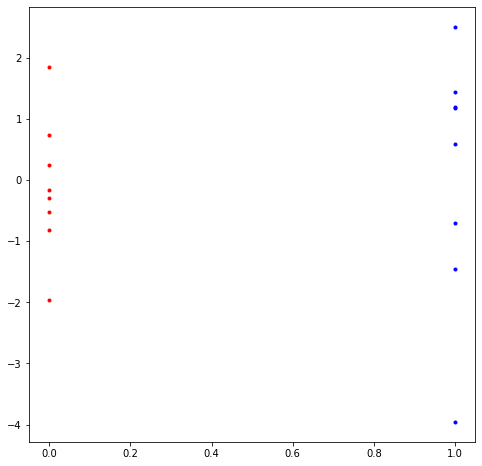

In [ ]:
npoints = 8
rng, r = random.split(rng)
points = random.normal(r, (npoints,))
rng, r = random.split(rng)
targets = random.normal(r, (npoints,)) * 2.
plt.figure(figsize=(8,8))
plt.plot(jp.zeros_like(points), points, '.', color='red')
plt.plot(jp.ones_like(points), targets, '.', color='blue')
plt.show()

What if we just take each point value and shift it to the corresponding target, pairing them in the random order they appear in our input vectors?

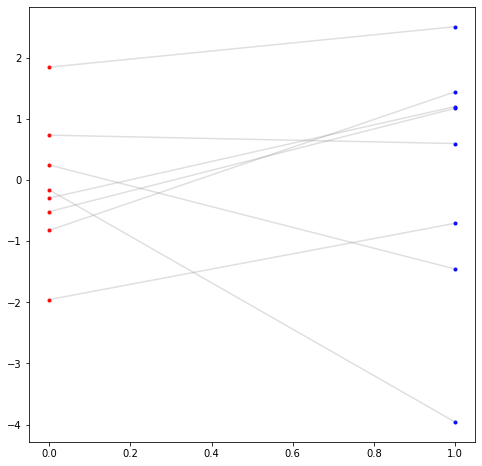

In [ ]:
delta = points - targets
plt.figure(figsize=(8,8))
plt.plot(jp.zeros_like(points), points, '.', color='red')
plt.plot(jp.ones_like(points), targets, '.', color='blue')
for i in range(npoints):
    plt.plot([0, 1], [points[i], points[i] - delta[i]], color='grey', alpha=.25)
plt.show()

We can calculate the total transport cost by adding up the absolute value of the `delta`s.

In [ ]:
float(jp.sum(jp.abs(delta)))

12.98681354522705

Is this optimal? Does this achieve the minimum transport cost, the smallest number of delta offsets needed to turn `points` into `targets`? We just picked the arbitrary mapping between the `npoints` generated in the `points` and `targets` arrays, let's try all of the permutations of the points - note this is `factorial(npoints)` operations which is fine for small `npoints` but quickly explodes in computational cost.

In [ ]:
@jax.jit
def comput_cost(index):
    points_p = points[index]
    delta = points_p - targets
    cost = jp.sum(jp.abs(delta))
    return cost

In [ ]:
costs = []
indexes = []
for index in permutations(range(npoints), npoints):
    index = jp.array(index)
    indexes.append(index)
    cost = comput_cost(index)
    costs.append(float(cost))

7.37250280380249 19.60373878479004


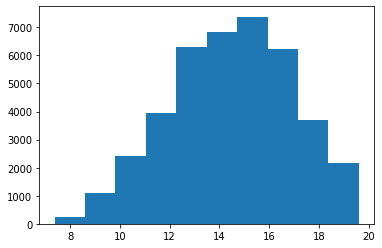

In [ ]:
print(min(costs), max(costs))
plt.hist(costs)
plt.show()

We can see that our transport cost is somewhere in the middle, let's take a look at the strategy that results in an optimal transport in the 1d case.

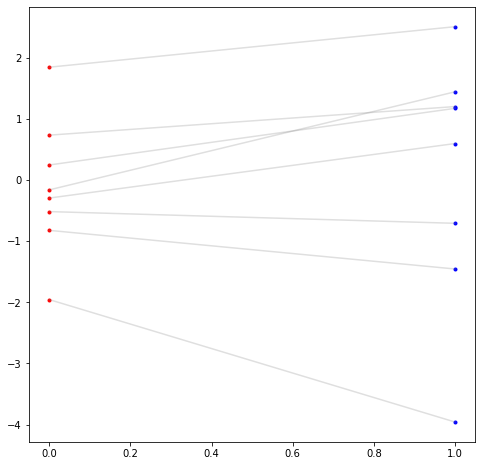

In [ ]:
argmin = jp.array(costs).argmin()
strategy = jp.array(indexes[argmin])
plt.figure(figsize=(8,8))
plt.plot(jp.zeros_like(points), points, '.', color='red')
plt.plot(jp.ones_like(points), targets, '.', color='blue')
for i in range(npoints):
    point = points[strategy[i]]
    delta = point - targets[i]
    plt.plot([0, 1], [point, point - delta], color='grey', alpha=.25)
plt.show()

It turns out that if you sort the points and sort the targets and perform the transport using that mapping you will always get the lowest (or one of multiple equal lowest) transport costs. This is really nice because searching for the optimal transport using permutations is computationally intractible where as sorting is a relatively cheap operation.

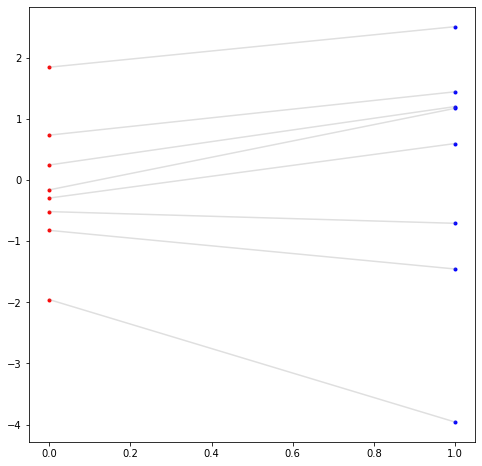

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(jp.zeros_like(points), points, '.', color='red')
plt.plot(jp.ones_like(points), targets, '.', color='blue')
points_sorted = points.sort()
targets_sorted = targets.sort()
for i in range(npoints):
    point = points_sorted[i]
    delta = point - targets_sorted[i]
    plt.plot([0, 1], [point, point - delta], color='grey', alpha=.25)
plt.show()

In [ ]:
float(jp.sum(jp.abs(points.sort() - targets.sort()))), costs[argmin]

(7.37250280380249, 7.37250280380249)